<a href="https://colab.research.google.com/github/recognita/EIM-for-Muscle-Construction-Detection/blob/main/challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**

In [59]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/AN2DL/challenge1"
%cd $current_dir

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL/challenge1


## ⚙️ **Libraries** **Import**

In [60]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from scipy.stats import norm, ttest_ind
from scipy.signal import welch


from sklearn.feature_selection import VarianceThreshold
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [61]:

# Set environment variables for dataset paths
os.environ["TRAIN_FILE"] = "pirate_pain_train.csv"
os.environ["TRAIN_URL"] = "1yRqrSB1JQwH09p1fXpO7lNfQZBl0PSBs"
os.environ["LABEL_FILE"] = "pirate_pain_train_labels.csv"
os.environ["LABEL_URL"] = "1BhWWiWQeBt9R4BcenRjzuuO0-VKQV8oJ"
os.environ["TEST_FILE"] = "pirate_pain_test.csv"
os.environ["TEST_URL"] = "1fXPfRottySriJF2uyRzpUgOI5affanMa"

# Check if Activity Recognition dataset exists and download if not
if not os.path.exists(os.environ["TRAIN_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TRAIN_URL} -O ${TRAIN_FILE}
    print("Activity Recognition dataset1 downloaded!")
else:
    print("Activity Recognition dataset1 already downloaded. Using cached data.")

if not os.path.exists(os.environ["LABEL_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${LABEL_URL} -O ${LABEL_FILE}
    print("Activity Recognition dataset2 downloaded!")
else:
    print("Activity Recognition dataset2 already downloaded. Using cached data.")

if not os.path.exists(os.environ["TEST_FILE"]):
    print("Downloading Activity Recognition dataset...")
    !gdown -q ${TEST_URL} -O ${TEST_FILE}
    print("Activity Recognition dataset3 downloaded!")
else:
    print("Activity Recognition dataset3 already downloaded. Using cached data.")



Activity Recognition dataset1 already downloaded. Using cached data.
Activity Recognition dataset2 already downloaded. Using cached data.
Activity Recognition dataset3 already downloaded. Using cached data.


## 🔎 **Exploration and Data Analysis**


In [62]:
# Load the dataset from a CSV file
dataset_train = pd.read_csv('pirate_pain_train.csv')
dataset_labels = pd.read_csv('pirate_pain_train_labels.csv')
dataset_test = pd.read_csv('pirate_pain_test.csv')

# Print the shape of the dataset
print(f"Dataset shape: {dataset_train.shape}")
print(f"Dataset shape: {dataset_labels.shape}")

# Display the first few rows of the dataset
dataset_train.head()
#661 is the number of people

Dataset shape: (105760, 40)
Dataset shape: (661, 2)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [63]:

#Everyone did 160 seconds or 2 min
counts_per_sample = dataset_train.groupby('sample_index')['time'].count()
all_160_timesteps = (counts_per_sample == 160).all()
print(f"All subjects have 160 time steps: {all_160_timesteps}")

All subjects have 160 time steps: True


In [64]:
print(dataset_train.isna().mean().sort_values(ascending=False).head(10))
print(dataset_train['sample_index'].nunique(), dataset_labels['sample_index'].nunique())

sample_index     0.0
time             0.0
pain_survey_1    0.0
pain_survey_2    0.0
pain_survey_3    0.0
pain_survey_4    0.0
n_legs           0.0
n_hands          0.0
n_eyes           0.0
joint_00         0.0
dtype: float64
661 661


- No missing values: All columns show a mean of 0.0 for null values, meaning the dataset is clean and doesn't require imputation or removal of NaNs.

- Subject count consistency: Both dataset_train and dataset_labels contain 661 unique sample_index entries, confirming alignment between features and labels.

dataset_train['sample_index'].nunique() = 661

dataset_labels['sample_index'].nunique() = 661

# Is it balance or imbalance?

In [65]:
dataset_labels['label'].value_counts()

,count
label,
no_pain,511
low_pain,94
high_pain,56


In [66]:
dataset_labels['label'].value_counts(normalize=True)

,proportion
label,
no_pain,0.773071
low_pain,0.142209
high_pain,0.084720


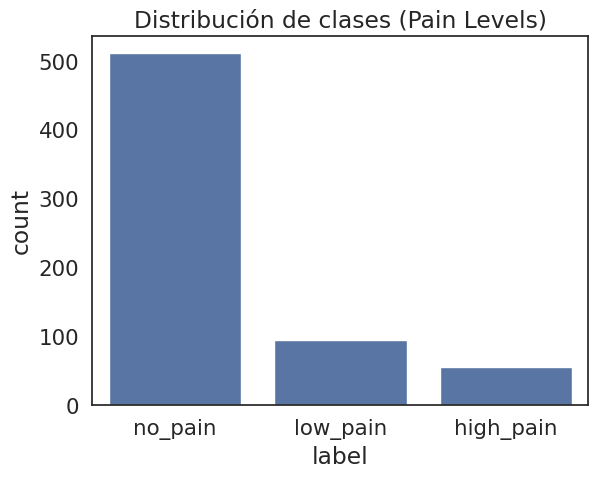

In [67]:
sns.countplot(data=dataset_labels, x='label')
plt.title('Distribución de clases (Pain Levels)')
plt.show()


Result: class imbalance, tend to no_pain

# NOISE


# Step 1: Visual inspection (plots)

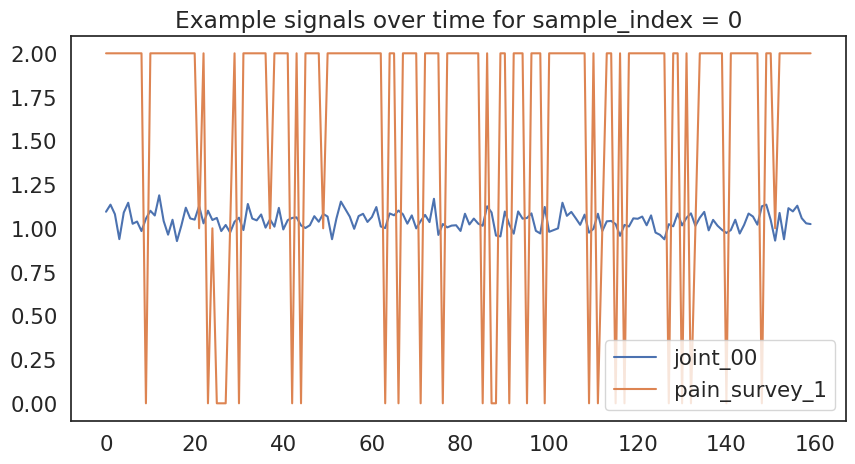

In [68]:
subject = dataset_train[dataset_train['sample_index'] == 0]

plt.figure(figsize=(10,5))
plt.plot(subject['time'], subject['joint_00'], label='joint_00')
plt.plot(subject['time'], subject['pain_survey_1'], label='pain_survey_1')
plt.legend()
plt.title('Example signals over time for sample_index = 0')
plt.show()

Find the kept-up average line,

In [69]:
selector = VarianceThreshold(threshold=1e-5)
selector.fit(dataset_train.select_dtypes(float))

low_var_cols = dataset_train.select_dtypes(float).columns[~selector.get_support()]
print("Low variance features:", low_var_cols.tolist())


Low variance features: ['joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_23', 'joint_24', 'joint_30']


This lines are to find sensors with unusually large or unstable values.

In [70]:
stats = dataset_train.describe().T
stats['range'] = stats['max'] - stats['min']
stats['std_over_mean'] = stats['std'] / stats['mean'].abs()

stats[['range', 'std_over_mean']].sort_values('std_over_mean', ascending=False).head(10)

,range,std_over_mean
joint_22,1.305001,131.015423
joint_21,1.442198,125.235102
joint_23,0.274241,34.686300
joint_25,0.947354,31.291376
joint_19,0.616061,20.430056
joint_20,1.096014,20.275951
joint_14,0.264232,18.363109
joint_18,0.728382,17.025618
joint_16,0.188807,15.010470
joint_13,0.073852,13.007174


The ones that we need to remove are:

['joint_13','joint_14', 'joint_15','joint_16','joint_18','joint_19','joint_20',
  'joint_21','joint_22','joint_23','joint_24','joint_25','joint_30']

# Class imbalance Solution

In [71]:
classes = np.unique(dataset_labels['label'])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=dataset_labels['label']
)
class_weights = dict(zip(classes, class_weights))
print(class_weights)


{'high_pain': np.float64(3.9345238095238093), 'low_pain': np.float64(2.3439716312056738), 'no_pain': np.float64(0.43118069145466403)}


So then in the model training you use this:

class_weights_tensor = torch.tensor([class_weights[c] for c in classes], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)



# Remove unnecessary or noisy features


In [72]:
# List of noisy / unnecessary features
noisy_features = [
    'joint_13', 'joint_14', 'joint_15', 'joint_16',
    'joint_18', 'joint_19', 'joint_20', 'joint_21',
    'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_30'
]

# Remove them off the dataset
dataset_train_clean = dataset_train.drop(columns=[c for c in noisy_features if c in dataset_train.columns], errors='ignore')
dataset_test_clean  = dataset_test.drop(columns=[c for c in noisy_features if c in dataset_test.columns], errors='ignore')

print("✅ Removed noisy features.")
print(f"Original dataset_train shape: {dataset_train.shape}")
print(f"Cleaned  dataset_train shape: {dataset_train_clean.shape}")
print(f"Original dataset_test shape:  {dataset_test.shape}")
print(f"Cleaned  dataset_test shape:  {dataset_test_clean.shape}")


✅ Removed noisy features.
Original dataset_train shape: (105760, 40)
Cleaned  dataset_train shape: (105760, 27)
Original dataset_test shape:  (211840, 40)
Cleaned  dataset_test shape:  (211840, 27)


Create NEW datasets with "disability" column and also drop the previous (3) separate ones.

In [73]:
# NEW copies of train and test sets with disability column
dataset_train_with_disability = dataset_train_clean.copy()
dataset_test_with_disability = dataset_test_clean.copy()

# Anything non-two (eyes, hands, legs)
def is_disabled(value): return value != 'two'

# Every row checks across n_legs, n_hands, n_eyes
dataset_train_with_disability['disability'] = dataset_train_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

dataset_test_with_disability['disability'] = dataset_test_with_disability[['n_legs', 'n_hands', 'n_eyes']].apply(
    lambda row: any(is_disabled(v) for v in row), axis=1 ).astype(int)

    # Convert it to float before training?

# Drop the old columns
dataset_train_with_disability = dataset_train_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])
dataset_test_with_disability = dataset_test_with_disability.drop(columns=['n_legs', 'n_hands', 'n_eyes'])

Display new disability set changes:

In [74]:
print("Original columns:", dataset_train_clean.columns[:10])
print("New columns:", dataset_train_with_disability.columns[:10])
print("Number of disabled subjects entries:", dataset_train_with_disability['disability'].sum())
disabled_subjects = dataset_train_with_disability.groupby('sample_index')['disability'].max().sum()
print("Number of unique disabled subjects:", disabled_subjects)
print("Disabled subjects are this percentage (%) of the total subjects:", disabled_subjects/dataset_train['sample_index'].nunique()*100)
dataset_train_with_disability.head() # Disability column at the end

Original columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes',
       'joint_00'],
      dtype='object')
New columns: Index(['sample_index', 'time', 'pain_survey_1', 'pain_survey_2',
       'pain_survey_3', 'pain_survey_4', 'joint_00', 'joint_01', 'joint_02',
       'joint_03'],
      dtype='object')
Number of disabled subjects entries: 960
Number of unique disabled subjects: 6
Disabled subjects are this percentage (%) of the total subjects: 0.9077155824508321


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_09,joint_10,joint_11,joint_12,joint_17,joint_26,joint_27,joint_28,joint_29,disability
0,0,0,2,0,2,1,1.094705,0.985281,1.018302,1.010385,...,1.050142,0.529555,0.447370,1.091046,0.000000,0.017592,0.013508,0.026798,0.027815,0
1,0,1,2,2,2,2,1.135183,1.021175,0.994343,1.052364,...,1.060313,0.446810,0.414432,1.045862,0.000009,0.013352,0.000000,0.013377,0.013716,0
2,0,2,2,0,2,2,1.080745,0.962842,1.009588,0.977169,...,1.011410,0.432499,0.431535,1.088221,0.000000,0.016225,0.008110,0.024097,0.023105,0
3,0,3,2,2,2,2,0.938017,1.081592,0.998021,0.987283,...,1.047223,0.478806,0.420665,1.096832,0.000035,0.011832,0.007450,0.028613,0.024648,0
4,0,4,2,2,2,2,1.090185,1.032145,1.008710,0.963658,...,1.044731,0.452906,0.476537,1.103968,0.000000,0.005360,0.002532,0.033026,0.025328,0


In [75]:
from sklearn.preprocessing import StandardScaler
scaler_disability = StandardScaler()

# Only numeric columns ("disability acts as a boolean -> does not count") Normalizing time!
numeric_columns_disability = [v for v in dataset_train_with_disability.columns
                           if v not in ['sample_index', 'disability']]

# Fitted on training set only
scaler_disability.fit(dataset_train_with_disability[numeric_columns_disability])

# Transform both training and testing sets
dataset_train_with_disability_normalized = dataset_train_with_disability.copy()
dataset_test_with_disability_normalized = dataset_test_with_disability.copy()

dataset_train_with_disability_normalized[numeric_columns_disability] = scaler_disability.transform(
    dataset_train_with_disability[numeric_columns_disability] )
dataset_test_with_disability_normalized[numeric_columns_disability] = scaler_disability.transform(
    dataset_test_with_disability[numeric_columns_disability] )

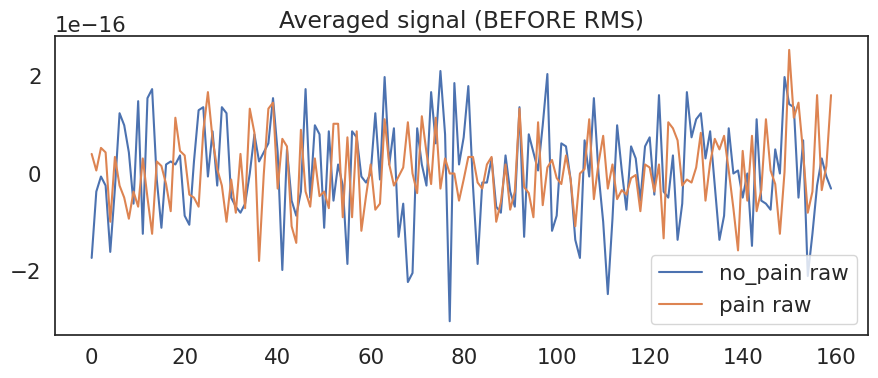

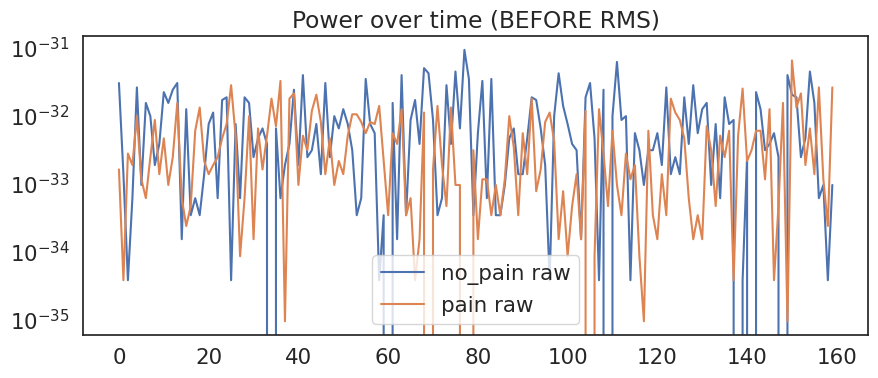

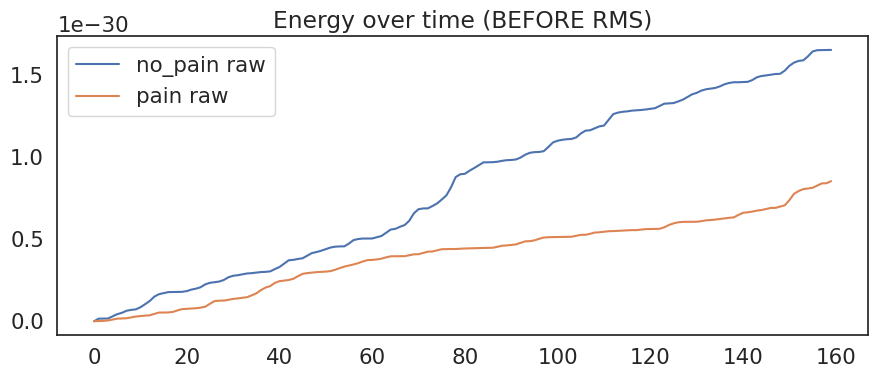

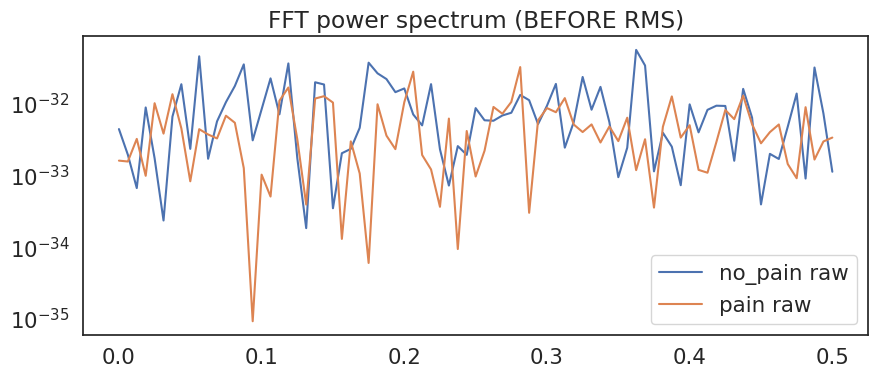

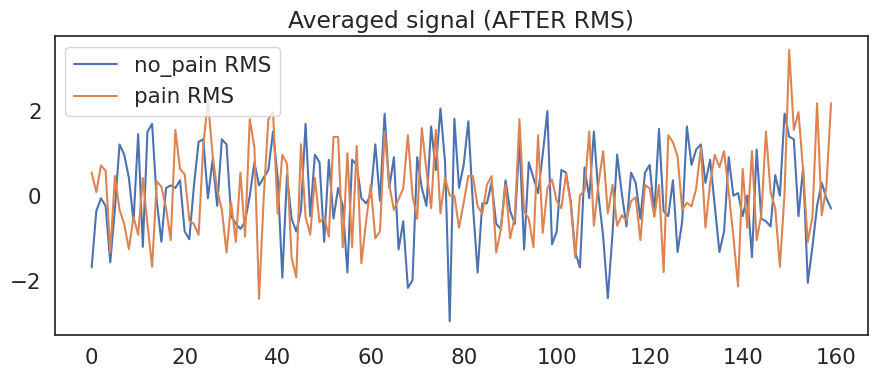

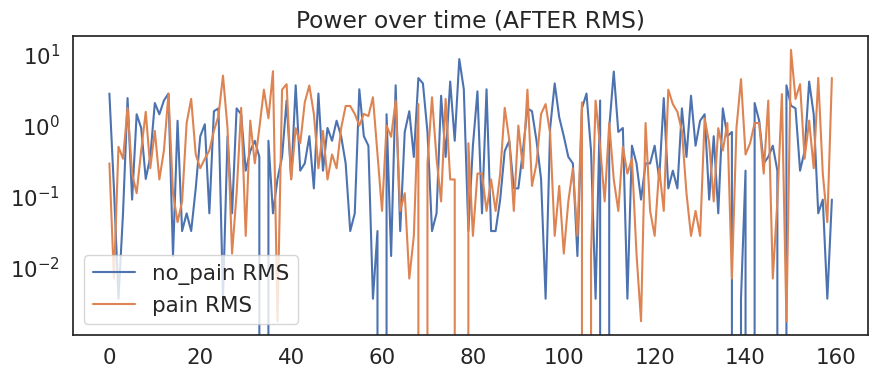

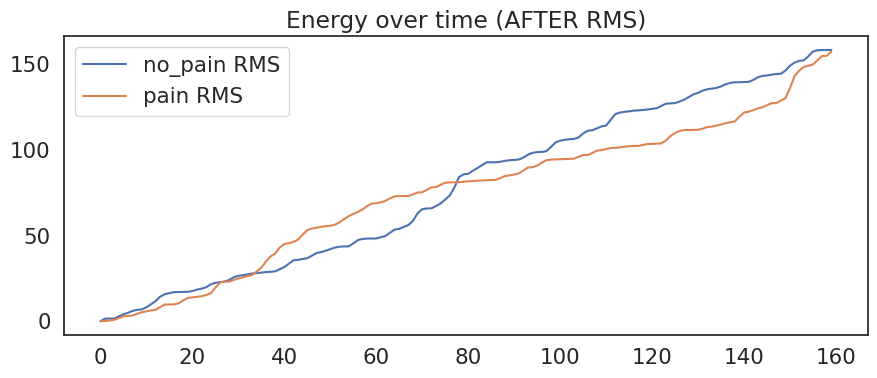

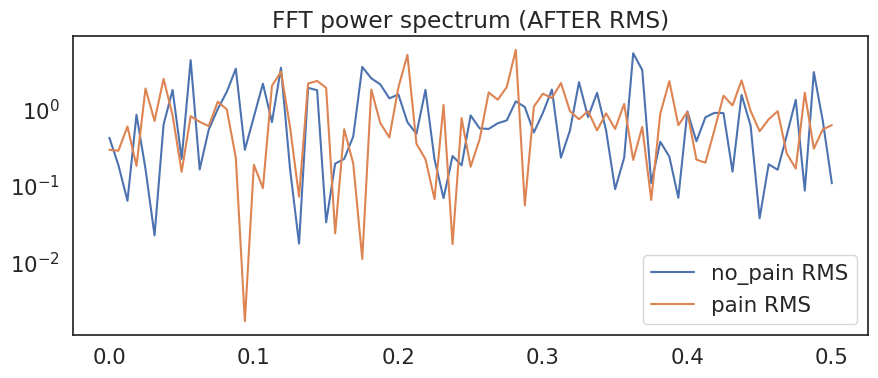

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ==================== вспомогательные функции ====================

def replace_nans_per_channel(X):
    X = X.astype(float)
    if np.isnan(X).any():
        med = np.nanmedian(X, axis=0, keepdims=True)
        X = np.where(np.isnan(X), med, X)
    return X

def average_reference_then_avg_across_channels(X):
    X = np.asarray(X, float)
    X_ref = X - X.mean(axis=1, keepdims=True)
    sig = X_ref.mean(axis=1)
    return sig

def rms_normalize_sample(x):
    x = np.asarray(x, float)
    r = np.sqrt(np.mean(x**2))
    if r == 0 or np.isnan(r):
        return x*0, 0
    return x / r, r

def cumulative_energy(t, p):
    E = np.zeros_like(p)
    dt = np.diff(t)
    incr = 0.5*(p[1:] + p[:-1]) * dt
    E[1:] = np.cumsum(incr)
    return E

def robust_fs_from_time(t):
    dts = np.diff(t)
    dt_med = np.median(dts)
    fs = 1.0 / dt_med
    is_uniform = np.std(dts) <= 0.01*np.mean(dts)
    return fs, dt_med, dts, is_uniform

def resample_to_uniform(t, x):
    fs, dt_med, _, _ = robust_fs_from_time(t)
    n = int(np.floor((t[-1] - t[0]) / dt_med)) + 1
    t_uni = t[0] + np.arange(n) * dt_med
    x_uni = np.interp(t_uni, t, x)
    return t_uni, x_uni, 1.0/dt_med

def fft_power_onesided(x, fs):
    x = np.asarray(x, float)
    n = len(x)
    fft_vals = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(n, d=1./fs)
    P = (np.abs(fft_vals)**2) / n
    return freqs, P


# ==================== 1) merge данных ====================

df = dataset_train_with_disability.merge(dataset_labels, on='sample_index', how='left')
df['is_pain'] = df['label'].map({'no_pain': False, 'low_pain': True, 'high_pain': True})
df = df[~df['is_pain'].isna()].copy()
df['is_pain'] = df['is_pain'].astype(bool)

joint_cols = sorted([c for c in df.columns if c.startswith('joint_')])


# ==================== 2) выбор одного pain и одного no_pain ====================

no_ids = df.loc[~df['is_pain'], 'sample_index'].unique()
yes_ids = df.loc[df['is_pain'],  'sample_index'].unique()

no_pain_id = no_ids[0]
pain_id    = yes_ids[0]

df_no  = df[df['sample_index']==no_pain_id].sort_values('time')
df_yes = df[df['sample_index']==pain_id].sort_values('time')

X_no  = replace_nans_per_channel(df_no[joint_cols].to_numpy(float))
X_yes = replace_nans_per_channel(df_yes[joint_cols].to_numpy(float))

t_no  = df_no['time'].to_numpy(float)
t_yes = df_yes['time'].to_numpy(float)


# ==================== 3) average reference + mean across channels ====================

sig_no_raw  = average_reference_then_avg_across_channels(X_no)
sig_yes_raw = average_reference_then_avg_across_channels(X_yes)


# ==================== 4) --- ГРАФИКИ ДО RMS НОРМАЛИЗАЦИИ --- ====================

# --- raw power ---
power_no_raw  = sig_no_raw**2
power_yes_raw = sig_yes_raw**2

# --- raw energy ---
energy_no_raw  = cumulative_energy(t_no,  power_no_raw)
energy_yes_raw = cumulative_energy(t_yes, power_yes_raw)

# --- raw FFT ---
fs_no_raw, _, _, uni_no_raw = robust_fs_from_time(t_no)
fs_yes_raw, _, _, uni_yes_raw = robust_fs_from_time(t_yes)

if not uni_no_raw:
    t_no_u_raw, sig_no_u_raw, fs_no_raw = resample_to_uniform(t_no, sig_no_raw)
else:
    t_no_u_raw, sig_no_u_raw = t_no, sig_no_raw

if not uni_yes_raw:
    t_yes_u_raw, sig_yes_u_raw, fs_yes_raw = resample_to_uniform(t_yes, sig_yes_raw)
else:
    t_yes_u_raw, sig_yes_u_raw = t_yes, sig_yes_raw

freqs_no_raw, P_no_raw = fft_power_onesided(sig_no_u_raw, fs_no_raw)
freqs_yes_raw, P_yes_raw = fft_power_onesided(sig_yes_u_raw, fs_yes_raw)


# ==================== 5) RMS нормализация ====================

sig_no,  rms_no  = rms_normalize_sample(sig_no_raw)
sig_yes, rms_yes = rms_normalize_sample(sig_yes_raw)

# мощность и энергия после RMS
power_no  = sig_no**2
power_yes = sig_yes**2

energy_no  = cumulative_energy(t_no,  power_no)
energy_yes = cumulative_energy(t_yes, power_yes)


# ==================== 6) FFT после RMS ====================

fs_no, _, _, uni_no = robust_fs_from_time(t_no)
fs_yes, _, _, uni_yes = robust_fs_from_time(t_yes)

if not uni_no:
    t_no_u, sig_no_u, fs_no = resample_to_uniform(t_no, sig_no)
else:
    t_no_u, sig_no_u = t_no, sig_no

if not uni_yes:
    t_yes_u, sig_yes_u, fs_yes = resample_to_uniform(t_yes, sig_yes)
else:
    t_yes_u, sig_yes_u = t_yes, sig_yes

freqs_no,  P_no  = fft_power_onesided(sig_no_u,  fs_no)
freqs_yes, P_yes = fft_power_onesided(sig_yes_u, fs_yes)


# ==================== 7) --- ВИЗУАЛИЗАЦИЯ ВСЕГО --- ====================

# ---------- RAW ----------
plt.figure(figsize=(9,4))
plt.plot(t_no, sig_no_raw, label="no_pain raw")
plt.plot(t_yes, sig_yes_raw, label="pain raw")
plt.title("Averaged signal (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(t_no, power_no_raw, label="no_pain raw")
plt.semilogy(t_yes, power_yes_raw, label="pain raw")
plt.title("Power over time (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(t_no, energy_no_raw, label="no_pain raw")
plt.plot(t_yes, energy_yes_raw, label="pain raw")
plt.title("Energy over time (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(freqs_no_raw, P_no_raw, label="no_pain raw")
plt.semilogy(freqs_yes_raw, P_yes_raw, label="pain raw")
plt.title("FFT power spectrum (BEFORE RMS)")
plt.legend(); plt.tight_layout(); plt.show()


# ---------- AFTER RMS ----------
plt.figure(figsize=(9,4))
plt.plot(t_no, sig_no, label="no_pain RMS")
plt.plot(t_yes, sig_yes, label="pain RMS")
plt.title("Averaged signal (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(t_no, power_no, label="no_pain RMS")
plt.semilogy(t_yes, power_yes, label="pain RMS")
plt.title("Power over time (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.plot(t_no, energy_no, label="no_pain RMS")
plt.plot(t_yes, energy_yes, label="pain RMS")
plt.title("Energy over time (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,4))
plt.semilogy(freqs_no, P_no, label="no_pain RMS")
plt.semilogy(freqs_yes, P_yes, label="pain RMS")
plt.title("FFT power spectrum (AFTER RMS)")
plt.legend(); plt.tight_layout(); plt.show()

Normalize the disability set with 0 mean and 1 standard deviation. **Ignoring** the string columns n_eyes, ...
Including time!

We compared the mean signal power between pain and no_pain conditions. If the mean power of pain samples is higher, it indicates that signal energy increases with pain; if it is lower, it would mean the opposite.

After computing the power using Welch’s method and performing a two-sample t-test, we obtained: t = 2.6033, p = 0.0096. Since p < 0.05, the difference is statistically significant, meaning it is very unlikely to be due to random variation.

The mean power values were:

no_pain: 8.81 × 10⁻³³

pain: 9.39 × 10⁻³³

Therefore, the pain condition shows a slightly higher mean signal power than no_pain. Although the difference is small, it is statistically significant and consistent with the biomedical hypothesis that pain is associated with increased signal energy or activity.